# Data Cleaning

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from better_profanity import profanity


from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

pd.set_option('display.max_rows', 500)

In [47]:
lyric_df = pd.read_csv('../data/full_lyrics_1941_2014.csv')

In [48]:
lyric_df.rename(columns = {'Unnamed: 0': 'song_rank'}, inplace = True)

lyric_df['song_rank'] = lyric_df['song_rank'] + 1

In [50]:
lyric_df.shape

(6304, 5)

In [6]:
print(f"{round(lyric_df['lyrics'].isnull().sum() / len(lyric_df) * 100, 2)}% of lyric values are null")

5.79% of lyric values are null


In [51]:
# dropping null values as these are only ~5% of the total song dataset
lyric_df = lyric_df.dropna()

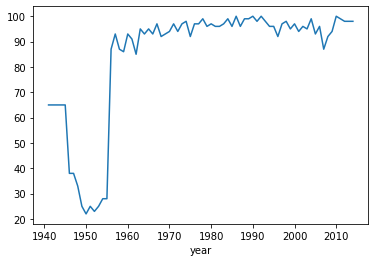

In [8]:
lyric_df.groupby('year')['year'].count().plot();

In [9]:
# lowercase all words in the lyrics column
lyric_df['lyrics'] = lyric_df['lyrics'].str.lower()

In [10]:
# adding column indicating the decade that the song made the billboard top 100

lyric_df['decade'] = (lyric_df['year']//10)*10 # integer divididing by 10 drops the year, multiplying by 10 again rounds the year to the nearest decade

In [56]:
lyric_df.head()

,song_rank,artist_name,song_title,year,lyrics
0,1,Glenn Miller,Chattanooga Choo Choo,1941,"Pardon me, boy Is that the Chattanooga choo ch..."
1,2,Sammy Kaye,Daddy,1941,Ladada ladada da dada Ladada ladada da dada La...
2,3,Artie Shaw,Stardust,1941,And now the purple dusk of twilight time Steal...
3,4,The Andrews Sisters,Boogie Woogie Bugle Boy,1941,He was a famous trumpet man from out Chicago w...
5,6,Jimmy Dorsey,Green Eyes,1941,"[Verse: Bob Eberly] Well, green eyes with thei..."


## Removing Annotation and API debris

In [12]:
lyric_df = lyric_df.replace("\[.*?\]", "", regex = True)

In [13]:
lyric_df = lyric_df.replace("youembedshare", "", regex = True) 
lyric_df = lyric_df.replace("embedshare", "", regex = True)
lyric_df = lyric_df.replace("yeahembedshare", "", regex = True) 
lyric_df = lyric_df.replace("urlcopyembedcopy", "", regex = True)

## Word/Character Counts & API Weirdness

The inclusion of a word count column has surfaced some irregularities with the Genius Lyric API. There are ~500 songs with excessive word counts (many greater than 100,000 words). These appear to be the text of screenplays, novels and poems that are completely unrelated to the song. As an example, the lyrics for the 1977 Star Wars theme (an instrumental, so I would have expected to not generate results) actually returned the entire text of a 1920 classic French novel 'The Guermantes Way'.
<p>
    It's unclear why this is happening. I had initially thought this may be placeholder text for instrumental songs, but this does not appear to be the case as songs with lyrics are also impacted. The incorrect lyrics also look to repeat, with some showing up on as many as five different songs. 
<p>
    In order to correct for this I've removed all songs which returned lyrics with a word count greater than 1,100. This dropped the overall count from 6,304 to 5,366. While not ideal, this still leaves enough data to perform analysis and modeling. 

In [14]:
# adding word count and unique word count for each song

lyric_df['word_count']=[len(x.split()) for x in lyric_df['lyrics'].tolist()]

In [15]:
lyric_df['characters'] = lyric_df['lyrics'].apply(len)
lyric_df['word_length'] = round(lyric_df['characters'] / (lyric_df['word_count']+1), 1)

In [17]:
lyric_df.drop_duplicates(subset = ['lyrics'], keep = False, inplace = True)

In [18]:
lyric_df.sort_values(by = 'word_count', ascending = False).head()

,song_rank,artist_name,song_title,year,lyrics,decade,word_count,characters,word_length
2702,99,London Symphony Orchestra,Star Wars (Main Title),1977,chapte...,1970,149170,825039,5.5
62,63,Harry James,By the Sleepy Lagoon,1941,madame s...,1940,96808,534728,5.5
829,26,Crests,16 Candles,1959,tale of king omar bin al-nu'uman and his sons ...,1950,95916,521888,5.4
195,36,Andrews Sisters and Les Paul Trio,Rumors Are Flying,1946,chapter two the mysteries of albertine — the ...,1940,84663,470283,5.6
272,18,Francis Craig,Beg Your Pardon,1948,a sentimental journey through france and italy...,1940,42195,216386,5.1


In [19]:
lyric_df = lyric_df[lyric_df['word_count'] < 1100]

In [20]:
lyric_df.shape

(5369, 9)

In [21]:
lyric_df.sort_values(by = 'word_count', ascending = False).head()

,song_rank,artist_name,song_title,year,lyrics,decade,word_count,characters,word_length
5362,59,D12,My Band,2004,"i don't know, dude i think everybody's all je...",2000,1088,5502,5.1
5319,16,Twista feat. Kanye West and Jamie Foxx,Slow Jamz,2004,"kanye, it's foxx, man i'm just sayin' i was t...",2000,1088,5495,5.0
5301,98,Eminem,Superman,2003,"mhmmm *inhales* you high, baby? yeah yeah? ta...",2000,1083,5661,5.2
1557,54,Simon and Garfunkel,The Sounds Of Silence,1966,"sitting now at the san jose airport, waiting f...",1960,1055,5602,5.3
4396,93,Ahmad,Back In The Day,1994,back in the days when i was young i'm not a k...,1990,1052,4943,4.7


## Lemmatize and Remove Punctuation

In [23]:
# Function to clean and separate titles using regex, and then Stem/Lem the cleaned text and filter stop words. Courtesy Breakfast Hour lesson. Thanks Katie!
def cleaner_rev(review):
    # Set token & instantiate Lem/Stem
    lemmatizer = WordNetLemmatizer()
    my_tokenizer = RegexpTokenizer("[\w']+|\$[\d\.]+") 
    
    # Tokenize words
    words = my_tokenizer.tokenize(review.lower())
    # What about stop words??
    stop_word_list = stopwords.words('english')
    no_stops = [i for i in words if i not in stop_word_list]
    # Lem/Stem
    rev_lem = [lemmatizer.lemmatize(i) for i in no_stops]
    # Put words back together
    return ' '.join(rev_lem)

In [24]:
# adding column of the cleaned lyrics
lyric_df['clean_lyrics'] = lyric_df['lyrics'].map(cleaner_rev)

/var/folders/x1/nngn1kws60393982xbp6dwyc0000gn/T/ipykernel_32782/54294245.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lyric_df['clean_lyrics'] = lyric_df['lyrics'].map(cleaner_rev)


## Adding Profanity Check

In [26]:
lyric_df['profanity'] = lyric_df['clean_lyrics'].apply(lambda x: profanity.contains_profanity(x))

/var/folders/x1/nngn1kws60393982xbp6dwyc0000gn/T/ipykernel_32782/1443096844.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lyric_df['profanity'] = lyric_df['clean_lyrics'].apply(lambda x: profanity.contains_profanity(x))


In [31]:
lyric_df['suggestive'] = np.where(lyric_df['profanity'] == True, 1, 0)

/var/folders/x1/nngn1kws60393982xbp6dwyc0000gn/T/ipykernel_32782/1006202724.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lyric_df['suggestive'] = np.where(lyric_df['profanity'] == True, 1, 0)


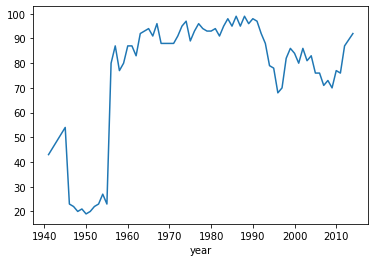

In [33]:
lyric_df.groupby('year')['year'].count().plot();

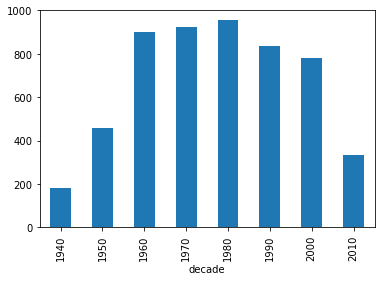

In [35]:
lyric_df.groupby('decade')['decade'].count().plot(kind = 'bar');

In [32]:
lyric_df.to_csv('../data/lyrics_clean.csv')